# Searching Scents

I want to explore the world of fragrances, and make a search tool where I can type in an arbitrary 'concept' and find matching scents.

This will be done based on the text descriptions. All the fragrance people will patiently explain that this is a terrible idea that won't capture any of the personal, subjective parts of smell. And they're absolutely right, but searching the text descriptions is still a lot of fun :)

## The Plan

Step 1 is to obtain a database of smells. Since I don't want to DDOS my local fumerie, I'll leave scraping for another demo and instead start with some nice data that I already have lying around.

Once we can get descriptions from this data, we'll want a way to 'embed' them somehow, probably using an API. I know the gemini API has free embeddings for low-volume use.

We'll need to set up a measure to compare embeddings, and to retrieve the best (or worst) matches for a query

And then we'll need an interface to let us search easily, which we'll build in FastHTML.

## Getting the data

Downloading and inspecting the data

In [ ]:
import httpx, json

In [ ]:
data = httpx.get('https://gist.githubusercontent.com/johnowhitaker/6fef140a3a47aa1ea049a8562270b0bf/raw/58ffbb9417aa75fc064766b0160534098e771d1f/fragrances.json').json()
len(data), data[0]

(469,
 {'name': 'A Grove by the Sea • Arquiste',
  'url': 'https://fumerie.com/arquiste/agrovebythesea',
  'fragrance_family_name': 'Woods',
  'fragrance_family_url': 'https://fumerie.com/fragrance-families/woods',
  'excerpt': '<div class="product-excerpt"><p><strong>House </strong><a href="https://www.fumerie.com/arquiste">Arquiste</a><br/><strong>Released</strong> 2024<br/><strong>Perfumer </strong><a href="https://fumerie.com/parfumeurs/rodrigo-flores-roux">Rodrigo Flores-Roux</a><br/><strong>Fragrance Family </strong><a href="https://fumerie.com/fragrance-families/woods">Woods</a><br/><strong>Notes</strong> Adriatic fig leaves, black olive, fleur de sel accord, Croatian clementine, Extra virgin olive oil accord, ripe fig fruit, thyme essence, rosemary essence, Mediterranean pine needle, fir balsam, Mediterranean cypress, red clay.</p><p><strong>Description</strong></p><p><strong>August 1508,</strong></p><p><strong>Lopud Island, Adriatic Sea.</strong></p><p>Lopud is an evergreen is

I want to add a 'text' field to each item, with the title + the excerpt. What's a good way to strip out all the HTML tags?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! For stripping HTML tags, you have a few good options. The most robust approach is using BeautifulSoup, which you already have available:

```python
from bs4 import BeautifulSoup

def extract_text(html):
    return BeautifulSoup(html, 'html.parser').get_text()
```

This will cleanly remove all HTML tags and give you just the text content.

Would you like to try implementing this to add the 'text' field to your fragrance data? Or would you prefer to see a different approach first?

In [ ]:
from bs4 import BeautifulSoup

def extract_text(html):
    return BeautifulSoup(html, 'html.parser').get_text()

print(extract_text(data[0]['excerpt']))

House ArquisteReleased 2024Perfumer Rodrigo Flores-RouxFragrance Family WoodsNotes Adriatic fig leaves, black olive, fleur de sel accord, Croatian clementine, Extra virgin olive oil accord, ripe fig fruit, thyme essence, rosemary essence, Mediterranean pine needle, fir balsam, Mediterranean cypress, red clay.DescriptionAugust 1508,Lopud Island, Adriatic Sea.Lopud is an evergreen island with lush fig and olive groves by the sea. From the port, dotted with Renaissance stone villas, the scent of fig and crushed olives is so strong that the salty sea breeze carries it beyond the harbor, towards forests of Mediterranean pine and cypress. Above, ancient chapels overlooking the harbor like sentinels are overgrown with wild thyme, fennel, and rosemary. The whole landscape an aromatic paradise of green fig, dried pine needles, wild herbs, and the subtle, nutty scent of olive oil.100 ml eau de parfum spray$220.001 ml eau de parfum sample$7.00


We lost the newlines, should I replace `<p>` with `\n`?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

That's a good observation! Yes, replacing `<p>` tags with newlines would help preserve the structure. You could do something like:

```python
html.replace('<p>', '\n').replace('</p>', '\n')
```

before passing it to BeautifulSoup, or handle it within the function.

Would you like to try modifying your `extract_text` function to preserve some of the paragraph breaks?

In [ ]:
html = data[0]['excerpt']
html = html.replace('<p>', '\n').replace('</p>', '\n').replace('<br/>', '\n')
print(extract_text(html))


House Arquiste
Released 2024
Perfumer Rodrigo Flores-Roux
Fragrance Family Woods
Notes Adriatic fig leaves, black olive, fleur de sel accord, Croatian clementine, Extra virgin olive oil accord, ripe fig fruit, thyme essence, rosemary essence, Mediterranean pine needle, fir balsam, Mediterranean cypress, red clay.

Description
August 1508,
Lopud Island, Adriatic Sea.

Lopud is an evergreen island with lush fig and olive groves by the sea. From the port, dotted with Renaissance stone villas, the scent of fig and crushed olives is so strong that the salty sea breeze carries it beyond the harbor, towards forests of Mediterranean pine and cypress. Above, ancient chapels overlooking the harbor like sentinels are overgrown with wild thyme, fennel, and rosemary. The whole landscape an aromatic paradise of green fig, dried pine needles, wild herbs, and the subtle, nutty scent of olive oil.

100 ml eau de parfum spray
$220.00

1 ml eau de parfum sample
$7.00



Now doing this to all of them:

In [ ]:
for item in data:
    html = item['excerpt'].replace('<p>', '\n').replace('</p>', '\n').replace('<br/>', '\n')
    item['text'] = item['name'] + '\n' + extract_text(html)

data[1]

{'name': 'Almond Suede • Arquiste',
 'url': 'https://fumerie.com/arquiste/almond-suede',
 'fragrance_family_name': None,
 'fragrance_family_url': None,
 'excerpt': '<div class="product-excerpt"><p><strong>House </strong><a href="https://www.fumerie.com/arquiste">Arquiste</a><br/><strong>Released</strong> 2024<br/><strong>Perfumer </strong>Calice Becker <br/><strong>Fragrance Family </strong>Gourmand<br/><strong>Notes</strong> Pink Peppercorn, Italian bergamot oil, Honeycomb absolute, Bitter Almond oil, Cistus concrete from Spain, North African neroli oil, Saffron accord, Orange flower accord, Candied sugar, Vanilla absolute, Pine tar from France, Suede Accord.</p><p><strong>Description</strong></p><p><strong>December 810,</strong></p><p><strong>Córdoba, Al-Andalus.</strong></p><p>In the golden age of Al-Andalus, confectioners crafted almond marzipan of unparalleled delicacy. The secret lay in the whispered exchange between Moorish and Spanish kitchens, transforming recipes of almond fl

## Embedding Text with Gemini

I need to grab the docs, then ask solveit how to embed text.`

In [ ]:
from dialoghelper import url2note

In [ ]:
# url2note('https://ai.google.dev/gemini-api/docs/embeddings#generate-embeddings')

Generating embeddings

Use the `embedContent` method to generate text embeddings:

### Python

```
from google import genai

client = genai.Client()

result = client.models.embed_content(
        model="gemini-embedding-001",
        contents="What is the meaning of life?")

print(result.embeddings)

```

### JavaScript

```
import { GoogleGenAI } from "@google/genai";

async function main() {

    const ai = new GoogleGenAI({});

    const response = await ai.models.embedContent({
        model: 'gemini-embedding-001',
        contents: 'What is the meaning of life?',
    });

    console.log(response.embeddings);
}

main();

```

### Go

```
package main

import (
    "context"
    "encoding/json"
    "fmt"
    "log"

    "google.golang.org/genai"
)

func main() {
    ctx := context.Background()
    client, err := genai.NewClient(ctx, nil)
    if err != nil {
        log.Fatal(err)
    }

    contents := []*genai.Content{
        genai.NewContentFromText("What is the meaning of life?", genai.RoleUser),
    }
    result, err := client.Models.EmbedContent(ctx,
        "gemini-embedding-001",
        contents,
        nil,
    )
    if err != nil {
        log.Fatal(err)
    }

    embeddings, err := json.MarshalIndent(result.Embeddings, "", "  ")
    if err != nil {
        log.Fatal(err)
    }
    fmt.Println(string(embeddings))
}

```

### REST

```
curl "https://generativelanguage.googleapis.com/v1beta/models/gemini-embedding-001:embedContent" \
-H "x-goog-api-key: $GEMINI_API_KEY" \
-H 'Content-Type: application/json' \
-d '{"model": "models/gemini-embedding-001",
     "content": {"parts":[{"text": "What is the meaning of life?"}]}
    }'

```

You can also generate embeddings for multiple chunks at once by passing them in as a list of strings.

### Python

```
from google import genai

client = genai.Client()

result = client.models.embed_content(
        model="gemini-embedding-001",
        contents= [
            "What is the meaning of life?",
            "What is the purpose of existence?",
            "How do I bake a cake?"
        ])

for embedding in result.embeddings:
    print(embedding)

```

### JavaScript

```
import { GoogleGenAI } from "@google/genai";

async function main() {

    const ai = new GoogleGenAI({});

    const response = await ai.models.embedContent({
        model: 'gemini-embedding-001',
        contents: [
            'What is the meaning of life?',
            'What is the purpose of existence?',
            'How do I bake a cake?'
        ],
    });

    console.log(response.embeddings);
}

main();

```

### Go

```
package main

import (
    "context"
    "encoding/json"
    "fmt"
    "log"

    "google.golang.org/genai"
)

func main() {
    ctx := context.Background()
    client, err := genai.NewClient(ctx, nil)
    if err != nil {
        log.Fatal(err)
    }

    contents := []*genai.Content{
        genai.NewContentFromText("What is the meaning of life?"),
        genai.NewContentFromText("How does photosynthesis work?"),
        genai.NewContentFromText("Tell me about the history of the internet."),
    }
    result, err := client.Models.EmbedContent(ctx,
        "gemini-embedding-001",
        contents,
        nil,
    )
    if err != nil {
        log.Fatal(err)
    }

    embeddings, err := json.MarshalIndent(result.Embeddings, "", "  ")
    if err != nil {
        log.Fatal(err)
    }
    fmt.Println(string(embeddings))
}

```

### REST

```
curl "https://generativelanguage.googleapis.com/v1beta/models/gemini-embedding-001:embedContent" \
-H "x-goog-api-key: $GEMINI_API_KEY" \
-H 'Content-Type: application/json' \
-d '{"model": "models/gemini-embedding-001",
     "content": [
        {"parts": [{"text": "What is the meaning of life?"}]},
        {"parts": [{"text": "What is the purpose of existence?"}]},
        {"parts": [{"text": "How do I bake a cake?"}]}
        ]
    }'

```

I have GEMINI_API_KEY defined, can you show me how to get embeddings for the first 5 fragrances and then for all of them?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Based on the docs you found, here's how to get embeddings for the first 5 fragrances:

```python
from google import genai
import os

client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

# Get embeddings for first 5 fragrances
first_5_texts = [item['text'] for item in data[:5]]
result = client.models.embed_content(
    model="gemini-embedding-001",
    contents=first_5_texts
)

print(f"Got {len(result.embeddings)} embeddings")
print(f"Each embedding has {len(result.embeddings[0])} dimensions")
```

Try this first to make sure it works! Then we can discuss how to handle all 469 fragrances efficiently.

In [ ]:
from google import genai
import os

In [ ]:
client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

In [ ]:
first_5_texts = [item['text'] for item in data[:5]]
first_5_texts

['A Grove by the Sea • Arquiste\n\nHouse Arquiste\nReleased 2024\nPerfumer Rodrigo Flores-Roux\nFragrance Family Woods\nNotes Adriatic fig leaves, black olive, fleur de sel accord, Croatian clementine, Extra virgin olive oil accord, ripe fig fruit, thyme essence, rosemary essence, Mediterranean pine needle, fir balsam, Mediterranean cypress, red clay.\n\nDescription\nAugust 1508,\nLopud Island, Adriatic Sea.\n\nLopud is an evergreen island with lush fig and olive groves by the sea. From the port, dotted with Renaissance stone villas, the scent of fig and crushed olives is so strong that the salty sea breeze carries it beyond the harbor, towards forests of Mediterranean pine and cypress. Above, ancient chapels overlooking the harbor like sentinels are overgrown with wild thyme, fennel, and rosemary. The whole landscape an aromatic paradise of green fig, dried pine needles, wild herbs, and the subtle, nutty scent of olive oil.\n\n100 ml eau de parfum spray\n$220.00\n\n1 ml eau de parfum 

In [ ]:
result = client.models.embed_content(model="gemini-embedding-001", contents=first_5_texts)
print(f"Got {len(result.embeddings)} embeddings")
print(f"Each embedding has {len(result.embeddings[0])} dimensions")

Got 5 embeddings


TypeError: object of type 'ContentEmbedding' has no len()

In [ ]:
result.embeddings[0]

ContentEmbedding(
  values=[
    -0.022429468,
    -0.026941853,
    -0.03531547,
    -0.12068482,
    -0.017778246,
    <... 3067 more items ...>,
  ]
)

Here the AI gave us code with a small mistake, but because we're in a dynamic environment, we can inspect result for ourselves, and see that we probably want `.values` to get the actual numbers. I'd normally clean this up and edit in the correct code, but here it is left in as an illustrative example.

In [ ]:
len(result.embeddings[0].values)

3072

### Aside: generating all embeddings

It turns out the free tier allows 100 requests per minute, so I'm collapsing + hiding this section here that shows the process of discovering that, and will resume with a new set of data in the next section.

Is there any reason I shouldn't just pass all 450+ texts in at once? This batch API seems nicer than doing them one by one.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're absolutely right! The batch API is much more efficient. There might be some practical limits to consider though:

1. **Rate limits** - API providers sometimes have limits on request size or tokens per minute
2. **Memory** - 450+ embeddings × 3072 dimensions could use a fair bit of RAM
3. **Error handling** - if one text fails, the whole batch might fail

But for 450 items, it's probably fine to try all at once. The Gemini docs show examples with multiple items, so it should handle it.

Want to try passing all the texts at once and see what happens?

In [ ]:
# all_embeddings = client.models.embed_content(model="gemini-embedding-001", contents=[o['text'] for o in data])
# len(all_embeddings)

Apparently the limit is 100 :) Can you show me the most concise way to do this in batches of 100?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Here's a concise way to process in batches of 100:

```python
all_embeddings = []
for i in range(0, len(data), 100):
    batch = [item['text'] for item in data[i:i+100]]
    result = client.models.embed_content(model="gemini-embedding-001", contents=batch)
    all_embeddings.extend(result.embeddings)
```

This will give you a single list with all embeddings. Want to try it?

In [ ]:
# import time
# all_embeddings = []

In [ ]:
# for i in range(len(all_embeddings), len(data), 100):
#     batch = [item['text'] for item in data[i:i+100]]
#     result = client.models.embed_content(model="gemini-embedding-001", contents=batch)
#     all_embeddings.extend(result.embeddings)
#     time.sleep(61) # Max 100 RPM according to https://ai.google.dev/gemini-api/docs/rate-limits

In [ ]:
# len(all_embeddings) # 469

Please add the embeddings to `data` and save as json, then give me the command/code to upload as a GIST called `fragrances_w_embeddings.json` using my `GITHUB_TOKEN`.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I'll help you add the embeddings to your data and create a gist. First, let's add the embeddings:

```python
for i, item in enumerate(data):
    item['embedding'] = all_embeddings[i].values

# Save as JSON
import json
with open('fragrances_w_embeddings.json', 'w') as f:
    json.dump(data, f)
```

Then to upload as a gist using your GitHub token:

```python
import httpx
import os

with open('fragrances_w_embeddings.json', 'r') as f:
    content = f.read()

response = httpx.post(
    'https://api.github.com/gists',
    headers={'Authorization': f'token {os.getenv("GITHUB_TOKEN")}'},
    json={
        'description': 'Fragrance database with embeddings',
        'public': True,
        'files': {
            'fragrances_w_embeddings.json': {'content': content}
        }
    }
)

print(response.json()['html_url'])
```

Try the first part first to make sure the embeddings get added correctly!

In [ ]:
# for i, item in enumerate(data): item['embedding'] = all_embeddings[i].values
# with open('fragrances_w_embeddings.json', 'w') as f: json.dump(data, f)

In [ ]:
# with open('fragrances_w_embeddings.json', 'r') as f: content = f.read()

# response = httpx.post(
#     'https://api.github.com/gists',
#     headers={'Authorization': f'token {os.getenv("GITHUB_TOKEN")}'},
#     json={
#         'description': 'Fragrance database with embeddings',
#         'public': True,
#         'files': {
#             'fragrances_w_embeddings.json': {'content': content}
#         }
#     }, timeout=30,
# )

# print(response.json()["html_url"]) 

(NB: This is the kind of tangential task where I'm happy offloading work to the AI)

## Querying our embeddings
We now have an embedding for each fragrance. Now we want a way to search these, which involves:

embedding the query text

comparing with all the embedding texts

In [ ]:
data = httpx.get('https://gist.githubusercontent.com/johnowhitaker/c2fc327d21b91619ef5c93e4f452ae6e/raw/ee5c184986f06d3751a00279eb11a2b8565e1ccf/fragrances_w_embeddings.json').json()
data[0].keys()

dict_keys(['name', 'url', 'fragrance_family_name', 'fragrance_family_url', 'excerpt', 'text', 'embedding'])

In [ ]:
def embed_text(text):
    return client.models.embed_content(model="gemini-embedding-001",contents=text).embeddings[0].values

e = embed_text("The smell of the Australian beach")
len(e), e[:5]

(3072, [0.013360883, -0.020682976, -0.012180225, -0.08668148, 0.0022025884])

OK, I have this set of 3072 numbers and I want to compare with those for all the fragrances. I think we want cossine similarity right? Can you explain that and show how we'd code it up with numpy? Take me through one small step at a time, I'll say 'continue' to move on so don't give me all the code at once.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Yes, cosine similarity is perfect for comparing embeddings. 

Cosine similarity measures the angle between two vectors, ignoring their magnitudes. It gives you a value between -1 and 1, where 1 means the vectors point in exactly the same direction (very similar), 0 means they're perpendicular (unrelated), and -1 means they point in opposite directions.

For embeddings, this is ideal because we care about the "direction" in the high-dimensional space rather than the actual magnitude of the numbers.

The formula is: `cosine_similarity = (A · B) / (|A| × |B|)`

Where `A · B` is the dot product, and `|A|`, `|B|` are the magnitudes (norms) of the vectors.

Ready for the next step, or would you like me to clarify anything about cosine similarity first?

Let's calculate it for some sample texts

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start with a simple example using numpy.

First, let's create two small sample vectors to see how cosine similarity works:

```python
import numpy as np

# Two sample vectors
a = np.array([1, 2, 3])
b = np.array([2, 4, 6])  # This is 2*a, so should be very similar

dot_product = np.dot(a, b)
norm_a = np.linalg.norm(a)
norm_b = np.linalg.norm(b)
cosine_sim = dot_product / (norm_a * norm_b)

print(f"Cosine similarity: {cosine_sim}")
```

Try this first - what do you expect the result to be, and why?

In [ ]:
import numpy as np

# Two sample vectors
a = np.array([1, 2, 3])
b = np.array([2, -4, 7]) # Playing with this, I see how the sim changes...

dot_product = np.dot(a, b)
norm_a = np.linalg.norm(a)
norm_b = np.linalg.norm(b)
cosine_sim = dot_product / (norm_a * norm_b)

print(f"Cosine similarity: {cosine_sim}")

Cosine similarity: 0.48261708906584017


OK, so we make an array of all our fragrance embeddings and then do cos sim for our query right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! Now let's work with your actual fragrance embeddings.

First, let's convert all the fragrance embeddings into a numpy array:

```python
# Convert all embeddings to a numpy array
fragrance_embeddings = np.array([item['embedding'] for item in data])
print(f"Shape: {fragrance_embeddings.shape}")
```

This will give us a 2D array where each row is one fragrance's embedding. Try this first and let me know what shape you get!

In [ ]:
# Convert all embeddings to a numpy array
fragrance_embeddings = np.array([item['embedding'] for item in data])
print(f"Shape: {fragrance_embeddings.shape}")

Shape: (469, 3072)


Continue

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You have 469 fragrances, each with 3072-dimensional embeddings.

Now let's calculate cosine similarity between your query embedding and all fragrances at once. We can use numpy's efficient operations:

```python
query_embedding = np.array(e)  # Your "Australian beach" query
similarities = np.dot(fragrance_embeddings, query_embedding) / (np.linalg.norm(fragrance_embeddings, axis=1) * np.linalg.norm(query_embedding))
print(f"Similarities shape: {similarities.shape}")
print(f"Min similarity: {similarities.min():.3f}, Max: {similarities.max():.3f}")
```

This computes all 469 similarities in one go! Try it and see what range of similarities you get.

In [ ]:
query_embedding = np.array(e)  # Your "Australian beach" query
similarities = np.dot(fragrance_embeddings, query_embedding) / (np.linalg.norm(fragrance_embeddings, axis=1) * np.linalg.norm(query_embedding))
print(f"Similarities shape: {similarities.shape}")
print(f"Min similarity: {similarities.min():.3f}, Max: {similarities.max():.3f}")

Similarities shape: (469,)
Min similarity: 0.464, Max: 0.631


OK I have a similarity score for each one. I want to see the distribution of scores and look at the top matches.

(array([ 42., 122., 149.,  71.,  46.,  24.,   8.,   4.,   1.,   2.]),
 array([0.46412996, 0.4808204 , 0.49751084, 0.51420128, 0.53089171,
        0.54758215, 0.56427259, 0.58096302, 0.59765346, 0.6143439 ,
        0.63103434]),
 <BarContainer object of 10 artists>)

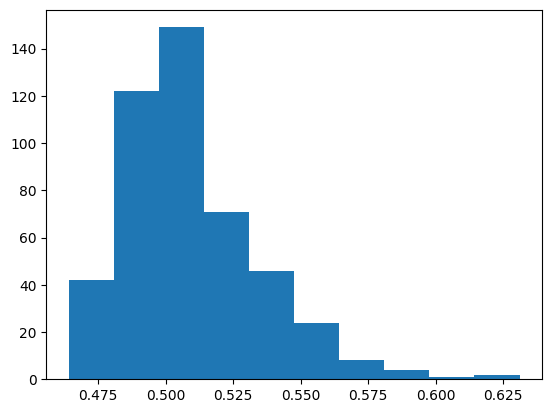

In [ ]:
from matplotlib import pyplot as plt

plt.hist(similarities)

Can you show me how to get the top 10 again?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Sure! To get the top 10 matches, you can use numpy's `argsort` to get the indices of the highest similarities:

```python
top_indices = np.argsort(similarities)[-10:][::-1]  # Get top 10, reverse for highest first
print("Top 10 matches:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. {data[idx]['name']} (similarity: {similarities[idx]:.3f})")
```

This will show you the fragrance names and their similarity scores, ranked from highest to lowest.

In [ ]:
top_indices = np.argsort(similarities)[-10:][::-1]  # Get top 10, reverse for highest first
print("Top 10 matches:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. {data[idx]['name']} (similarity: {similarities[idx]:.3f})")
    print(data[idx]['text'])

Top 10 matches:
1. Sydney Rock Pool • Arquiste (similarity: 0.631)
Sydney Rock Pool • Arquiste

House Arquiste
Released 2018
Perfumer Rodrigo Flores-Roux 
Fragrance Family Marine
Notes Australian sandalwood, mineral accord, coconut skin accord, driftwood note, narcissus absolute, frangipani, jasmine sambac, seaweed, ambermax, and sea salt

Description Golden Hour, January 2016, Sydney.
The surf crashes against the sandstone rocks. Your skin glows in the warm sun underneath a blazing Australian sky. As you climb out of the water, a gentle breeze blows through the nearby jasmine and frangipani trees, mixing with the subtle scent of sea, salt, and rock.
Take the moment to soak it all up, and dive down under with this evocative fragrance.
Arquiste’s more traditional take on the marine fragrance genre adds a touch so modern it feels ahead of its time; incorporating white florals to great and nuanced effect, and sandalwood to accentuate the coconut note just above the skin.

100 ml eau de pa

OK, let's wrap this in a `search(q, n=5)` function that takes a query and returns the top n matches.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great idea! Here's a clean search function:

```python
def search(q, n=5):
    query_embedding = np.array(embed_text(q))
    similarities = np.dot(fragrance_embeddings, query_embedding) / (
        np.linalg.norm(fragrance_embeddings, axis=1) * np.linalg.norm(query_embedding)
    )
    top_indices = np.argsort(similarities)[-n:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({
            'name': data[idx]['name'],
            'similarity': similarities[idx],
            'text': data[idx]['text']
        })
    return results
```

Want to test it with a different query to see how it works?

In [ ]:
def search(q, n=5):
    query_embedding = np.array(embed_text(q))
    similarities = np.dot(fragrance_embeddings, query_embedding) / (
        np.linalg.norm(fragrance_embeddings, axis=1) * np.linalg.norm(query_embedding)
    )
    top_indices = np.argsort(similarities)[-n:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({**data[idx], 'similarity': similarities[idx]})
    return results

results = search("A field of flowers")
[r['name'] for r in results]

['Fox in the Flowerbed • Imaginary Authors',
 'Dolceacqua • Masque',
 'Mystic Bliss • Goldfield & Banks',
 'Pacific Rock Flower • Goldfield & Banks',
 'Silver Saffron • Une Nuit Nomade']

## Making a cool interface

OK, now that we can search the embeddings, let's make a quick little UI to serve up the results nicely!

In [ ]:
results[0].keys() # Remonding myself and solveit what a result looks like

dict_keys(['name', 'url', 'fragrance_family_name', 'fragrance_family_url', 'excerpt', 'text', 'embedding', 'similarity'])

In [ ]:
from fasthtml.common import *
from fasthtml.jupyter import *
from monsterui.all import *

In [ ]:
# We're going to build this in monsterui in solveit, so I'll run this rather than using `show` each time
render_ft()

OK solveit, I don't feel like doing much UI today. Can you search the monsterUI docs and come up with a nice `ResultCard(r)` component that shows the fragrance name, family and text, with the similarity to the query shown somewhere? Clicking the name should take you to the fragrance in a new tab, clicking the fragrance family should do the same but for the family url.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

<details class='tool-usage-details'>

 `read_url({"url": "https://monsterui.answer.ai/"})`
  - `&#x27;* Getting Started\n    * Getting Started\n    * Tutorial App\n  * API Reference\n    * Accordion   Link\n    * Button   Link\n    * Cards\n    * Charts\n    * Containers\n    * Dividers\n    * Forms\n    * Html\n    * Icons   Images\n    * Layout\n    * Lightbox\n    * Lists\n    * Loading\n    * Markdown\n    * Modals\n    * Navigation\n    * Notifications\n    * Sliders\n    * Steps\n    * Tables\n    * Theme   Headers\n    * Typography\n  * Guides\n    * Spacing\n    * Layout\n  * Examples\n    * Task\n    * Card\n    * Dashboard\n    * Form\n    * Music\n    * Auth\n    * Playground\n    * Mail\n    * Ticket\n    * Scrollspy\n  * Theme\n\n  * Getting Started\n    * Getting Started\n    * Tutorial App\n  * API Reference\n    * Accordion   Link\n    * Button   Link\n    * Cards\n    * Charts\n    * Containers\n    * Dividers\n    * Forms\n    * Html\n    * Icons   Images\n    * Layout\n    * Lightbox\n    * Lists\n    * Loading\n    * Markdown\n    * Modals\n    * Navigation\n    * Notifications\n    * Sliders\n    * Steps\n    * Tables\n    * Theme   Headers\n    * Typography\n  * Guides\n    * Spacing\n    * Layout\n  * Examples\n    * Task\n    * Card\n    * Dashboard\n    * Form\n    * Music\n    * Auth\n    * Playground\n    * Mail\n    * Ticket\n    * Scrollspy\n  * Theme\n\n# MonsterUI\n\nMonsterUI is a UI framework for FastHTML for building beautiful web interfaces with minimal code. It combines the simplicity of Python with the power of Tailwind. Perfect for data scientists, ML engineers, and developers who want to quickly turn their Python code into polished web apps without the complexity of traditional UI frameworks. Follows semantic HTML patterns when possible.\n\nMonsterUI adds the following Tailwind-based libraries [Franken UI](https://franken-ui.dev/) and [DaisyUI](https://daisyui.com/) to FastHTML, as well as Python\&#x27;s [Mistletoe](https://github.com/miyuchina/mistletoe) for Markdown, [HighlightJS](https://highlightjs.org/) for code high…`

</details>


<details class='tool-usage-details'>

 `read_url({"url": "https://monsterui.answer.ai/cards"})`
  - `HTTPStatusError: Client error &#x27;400 Bad Request&#x27; for url &#x27;https://monsterui.answer.ai/cards&#x27; For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/400`

</details>


<details class='tool-usage-details'>

 `read_url({"url": "https://monsterui.answer.ai/api_ref/docs_cards"})`
  - `&#x27;* Getting Started\n    * Getting Started\n    * Tutorial App\n  * API Reference\n    * Accordion   Link\n    * Button   Link\n    * Cards\n    * Charts\n    * Containers\n    * Dividers\n    * Forms\n    * Html\n    * Icons   Images\n    * Layout\n    * Lightbox\n    * Lists\n    * Loading\n    * Markdown\n    * Modals\n    * Navigation\n    * Notifications\n    * Sliders\n    * Steps\n    * Tables\n    * Theme   Headers\n    * Typography\n  * Guides\n    * Spacing\n    * Layout\n  * Examples\n    * Task\n    * Card\n    * Dashboard\n    * Form\n    * Music\n    * Auth\n    * Playground\n    * Mail\n    * Ticket\n    * Scrollspy\n  * Theme\n\n  * Getting Started\n    * Getting Started\n    * Tutorial App\n  * API Reference\n    * Accordion   Link\n    * Button   Link\n    * Cards\n    * Charts\n    * Containers\n    * Dividers\n    * Forms\n    * Html\n    * Icons   Images\n    * Layout\n    * Lightbox\n    * Lists\n    * Loading\n    * Markdown\n    * Modals\n    * Navigation\n    * Notifications\n    * Sliders\n    * Steps\n    * Tables\n    * Theme   Headers\n    * Typography\n  * Guides\n    * Spacing\n    * Layout\n  * Examples\n    * Task\n    * Card\n    * Dashboard\n    * Form\n    * Music\n    * Auth\n    * Playground\n    * Mail\n    * Ticket\n    * Scrollspy\n  * Theme\n\n# Cards API Reference\n\n### Example Usage\n\nSee Source\n\nSee Output\n\nHeader\n\nA card with header and footer\n\nInput\n\nRange\n\nFooter Submit Button\n\n\ndef ex_card():\n    return Card(\n        Form(LabelInput(&quot;Input&quot;),\n             LabelRange(&quot;Range&quot;)),\n        header=Div(\n            CardTitle(&quot;Header&quot;),\n            P(&quot;A card with header and footer&quot;,cls=TextPresets.muted_sm)),\n        footer=DivLAligned(Button(&quot;Footer Submit Button&quot;)))\n\n\n\nSee Source\n\nSee Output\n\n![](https://picsum.photos/200/200?random=12)\n\n#### Creating Custom FastHTML Tags for Markdown Rendering\n\nA step by step tutorial to rendering mar…`

</details>

Based on the MonsterUI docs, here's a nice `ResultCard` component for your fragrances:

```python
def ResultCard(r):
    family_link = A(r['fragrance_family_name'], href=r['fragrance_family_url'], target="_blank") if r['fragrance_family_name'] else "—"
    
    return Card(
        P(r['text'][:300] + "..." if len(r['text']) > 300 else r['text']),
        header=Div(
            A(H3(r['name']), href=r['url'], target="_blank"),
            P(f"Family: {family_link}", cls=TextPresets.muted_sm)),
        footer=DivLAligned(
            Small(f"Similarity: {r['similarity']:.3f}", cls=TextT.muted)),
        cls=CardT.hover)
```

This creates a hoverable card with the name as a clickable header, truncated text, and similarity score in the footer. Want to try it out?

In each dialog, you can choose how you want to work and which pieces you want to learn and understand yourself vs offloading to the AI. Here, I lean a lot more heavily on solveit than I did for learning about the embeddings - and even then I have mostly chosen to coast along here, not diving too deep since these are topics I'm somewhat familiar with. Let's see how solveit did with this bit of UI design!

In [ ]:
def ResultCard(r):
    family_link = A(r['fragrance_family_name'], href=r['fragrance_family_url'], target="_blank") if r['fragrance_family_name'] else "—"
    
    return Card(
        P(r['text']),
        header=Div(
            A(H3(r['name']), href=r['url'], target="_blank"),
            P("Family: ", family_link, cls=TextPresets.muted_sm)),
        footer=DivLAligned(
            Small(f"Similarity: {r['similarity']:.3f}", cls=TextT.muted)),
        cls=CardT.hover)

ResultCard(results[0])

<div>
  <div class="uk-card uk-card hover:shadow-lg hover:-translate-y-1 transition-all duration-200">
    <div class="uk-card-header ">
      <div>
<a href="https://fumerie.com/house/imaginary-authors/fox-in-the-flowerbed" target="_blank">          <h3 class="uk-h3 ">Fox in the Flowerbed • Imaginary Authors</h3>
</a>        <p class="text-gray-500 dark:text-gray-200 text-sm">
Family: <a href="https://fumerie.com/fragrance-families/floral" target="_blank">Floral</a>        </p>
      </div>
    </div>
    <div class="uk-card-body space-y-6">
      <p>Fox in the Flowerbed • Imaginary Authors

House Imaginary Authors
Released 2021
Perfumer Josh Meyer
Fragrance Family Floral
Notes jasmin, tulips, frankincense, wildflower honey, pink peppercorns, silver thistle, Alpine air

DescriptionRescued from obscurity by students who tracked down the reclusive author at a remote cabin in the Austrian Alps, this collection of alpine fairy tales marks the return of enigmatic writer, Chunhua Luli. The main characters in these stories are wild animals but the tender lessons they impart cut straight to the heart of the human condition. In the titular story, a young fox becomes obsessed with a butterfly, only to learn the hazards of infatuation. Other themes explored include the advantages of unflagging ambition, the importance and impact of beautiful objects, the pursuit of serenity, and the power of positive thinking. Forty years after her remarkable debut, Luli once again reminds us we are all animals, connected by an expansive and ever-changing ecosystem much larger than ourselves.
Explore the candle version here
Explore the soap version here
50 ml eau de parfum spray
$115.00

14 ml eau de parfum spray
$46.00

1 ml eau de parfum sample
$4.00
</p>
    </div>
    <div class="uk-card-footer ">
      <div class="flex justify-start items-center space-x-4">
<small class="text-sm text-gray-500 dark:text-gray-200">Similarity: 0.589</small>      </div>
    </div>
  </div>
<script>if (window.htmx) htmx.process(document.body)</script></div>


OK, not bad with a few small tweaks - certainly a little faster than coding it by hand. Now let's make a search page.

There will be a text box and a button, submitting will send a request to a `search` route, which will return 5 result cards. 

Let's see if solveit knows enough FastHTML and HTMX to make this happen without any docs!

Solveit, do you think you could write a `search_page` function that renders the search box, and a `search` route to do the searching, as described above?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, I can help with that! Here's a basic structure:

```python
def search_page():
    return Div(
        H1("Fragrance Search"),
        Form(
            Input(placeholder="Search fragrances...", name="q", id="search-input"),
            Button("Search", type="submit"),
            hx_post="/search", hx_target="#results"
        ),
        Div(id="results")
    )
```

And for the route:

```python
@app.post("/search")
def search_route(q: str):
    results = search(q, 5)
    return Div(*[ResultCard(r) for r in results])
```

Would you like me to adjust anything about this approach, or shall we try it out?

OK - looks promising. Let's create the app + start a server as shown in the welcome_to_solveit demo dialog and see if it works! We may as well make the search page a route too, so that we can share `<your public url>/fragrance_search` with friends!

In [ ]:
app = FastHTML(hdrs = Theme.blue.headers())
srv = nb_serve(app)

In [ ]:
@app.route
def fragrance_search():
    return Titled("Fragrance Search",
        Form(
            DivLAligned(
                Input(placeholder="Search fragrances...", name="q", id="search-input"),
                Button("Search", type="submit")
            ),
            hx_post="/search", hx_target="#results",
            cls='pt-5 pb-5'
        ),
        Div(id="results")
    )

In [ ]:
@app.post("/search")
def search_route(q: str):
    results = search(q, 5)
    return Div(*[ResultCard(r) for r in results])

In [ ]:
fragrance_search()[1]

<div>
<main>    <div class="uk-container uk-container-xl">
      <h1 class="uk-h1 ">Fragrance Search</h1>
<form enctype="multipart/form-data" hx-post="/search" hx-target="#results" class="pt-5 pb-5">        <div class="flex justify-start items-center space-x-4">
          <input placeholder="Search fragrances..." name="q" id="search-input" class="uk-input ">
<button type="submit" class="uk-btn uk-btn-default">Search</button>        </div>
</form>      <div id="results"></div>
    </div>
</main><script>if (window.htmx) htmx.process(document.body)</script></div>


And here's the result:


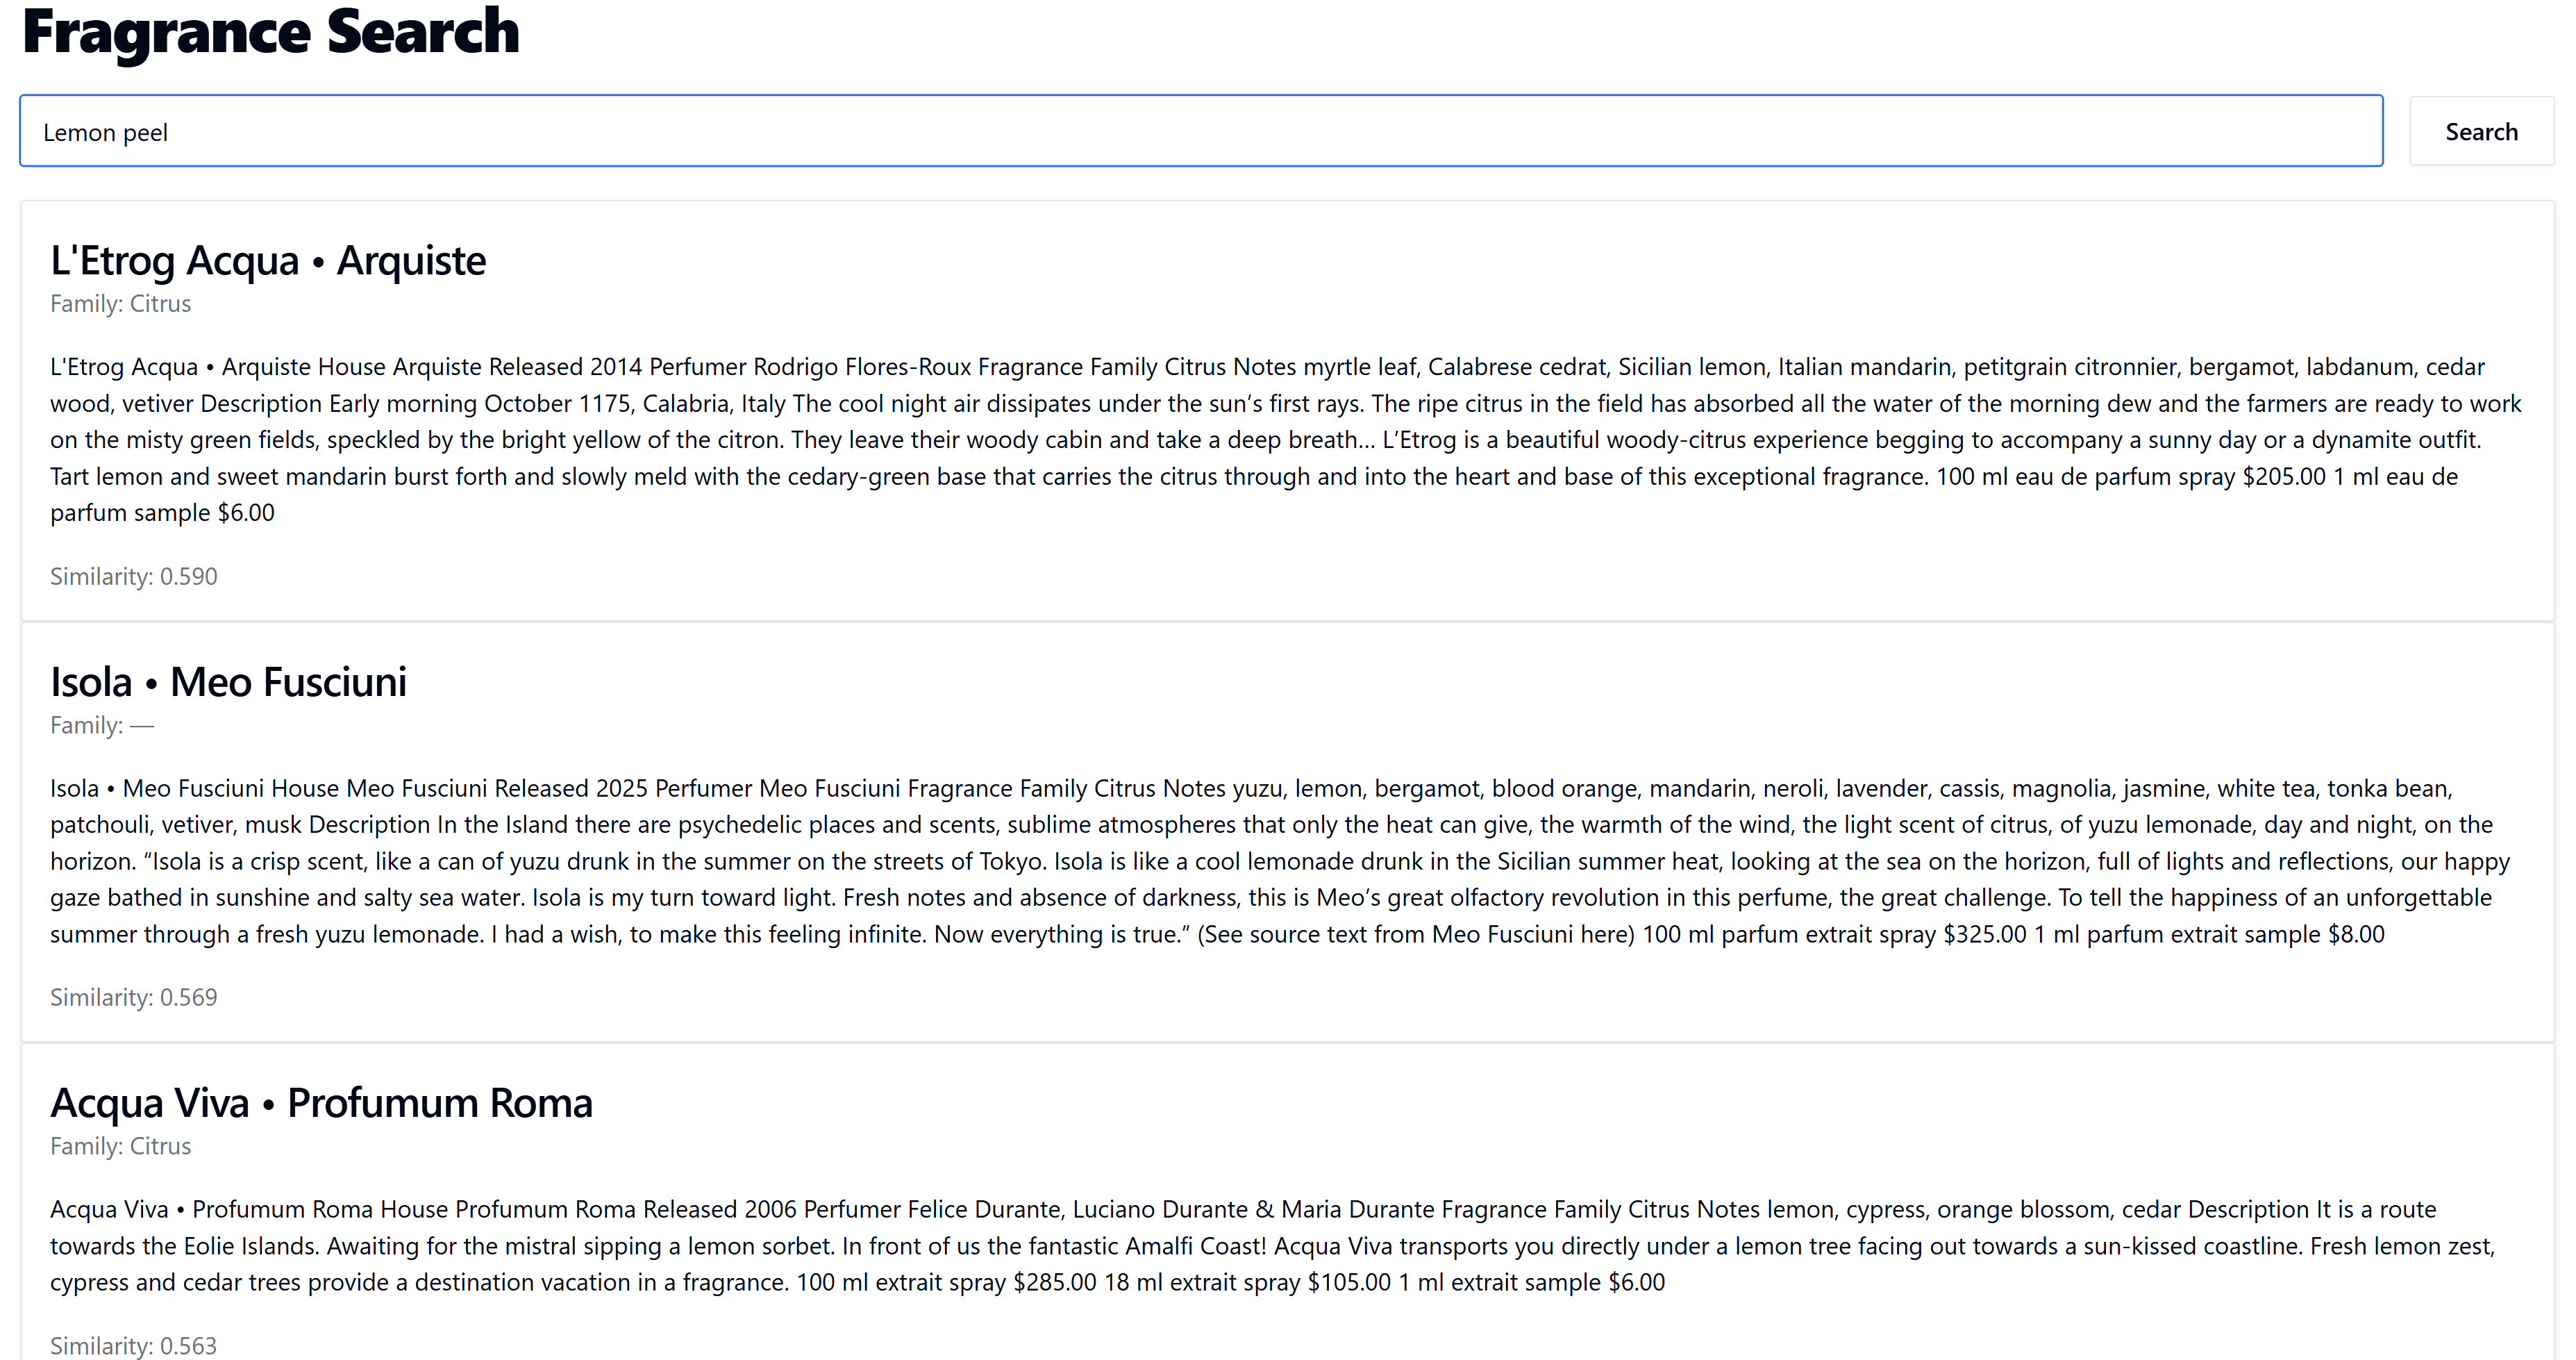


## Commentary

This dialog was made by Johno. It's designed to show an exploration of a task. It is artificial, since this is a task I've done before, but tries to capture the flow of working on something vaguely familiar: making notes to yourself with plans and observations, asking solveit for info and bits of code but then tweaking + understanding them and running them only when happy. I used learning mode, and didn't spend time editing AI responses much, since it suited the half-lazy half-careful mood I was in. I've left in pieces that didn't work - e.g. where the Gemini embeddings API hit rate limits and batch size limits. Since that is a once-off piece of code, I'd normally clean it up afterwards to keep the context tidy, and save the results to disk for later re-use.

If you are running this and need to re-start the server, you can run:

```python
srv.should_exit = True
wait_port_free(8000)
```

Do this before re-running the message with `nb_serve`. 